# TP1 CSM 23/24

- Elementos do grupo:
João Maia 44754 e Tatiana Damaya 50299

- Docente:
André Lourenço


Este Trabalho explora os conceitos de compressão de dados sem perdas baseados na teoria da informação. 

In [277]:
from heapq import heappop, heappush, heapify
from collections import defaultdict
from time import time
from os import path
import numpy as np
import matplotlib.pyplot as plt
import math
import os

### 1. Elabore uma função (gen_huff_table) que gere uma tabela com o código binário para cada símbolo de um dado conjunto, usando o método de Huffman. Esta função deve ter como parâmetros de entrada um conjunto de símbolos e as suas probabilidades (ou em alternativa pode usar o número de ocorrências de cada símbolo, dado pelo seu histograma). Também pode em alternativa gerar não uma tabela mas outra estrutura de dados com os códigos pretendidos (ex: dicionário).

Para realizarmos esta função, recorremos ao conjunto de slides (Slides 2a - Codificação entrópica - Shanno-Fano e Huffman) disponibilizado no moodle, onde no slide 20 encontrámos os procedimentos para realizar o algoritmo Huffman:

1 – Colocar os símbolos numa lista por ordem decrescente de
probabilidade

2 – Escolher os dois simbolos com menor frequência e agrupálos num novo símbolo com probabilidade igual à soma destes
dois.

3 – Inserir o novo símbolo na lista ordenada.

4 – Voltar ao ponto 2 até que cada a lista tenha apenas um
símbolo.

5 – Atribuir códigos partindo do ultimo símbolo criado.

In [278]:
def gen_huff_table(symbols, frequencies):
    # Create a defaultdict to store symbol frequencies
    freq_lib = defaultdict(float)
    # Iterate through the symbols and frequencies
    for sym, freq in zip(symbols, frequencies):
        # Store the frequency of each symbol in freq_lib
        freq_lib[sym] = freq

    # Create a heap containing frequency-symbol pairs
    heap = [[fq, [sym, ""]] for sym, fq in freq_lib.items()]
    # Convert the list into a heap
    heapify(heap)

    # Build the Huffman tree
    while len(heap) > 1:
        # Pop the smallest two elements from the heap
        right = heappop(heap)
        left = heappop(heap)

        # Assign '0' to the right branch and '1' to the left branch
        for pair in right[1:]:
            pair[1] = '0' + pair[1]
        for pair in left[1:]:
            pair[1] = '1' + pair[1]

        # Push the combined node back to the heap
        heappush(heap, [right[0] + left[0]] + right[1:] + left[1:])

    # Extract the Huffman codes from the final two nodes
    huffman_list = right[1:] + left[1:]

    # Convert the Huffman codes into a dictionary
    huffman_dict = {a[0]: a[1] for a in huffman_list}

    # Sort Huffman table by symbol occurrences
    sorted_huffman_table = {symbol: huffman_dict[symbol] for symbol, _ in sorted(freq_lib.items(), key=lambda x: (-x[1], x[0]))}

    return sorted_huffman_table

def sort_symbols_occurences(symbols):
    occurrences = []
    # Count occurrences of each symbol
    for symbol in set(symbols):
        occurrences.append((symbol, symbols.count(symbol)))
        # Sort occurrences by count and symbol (to maintain the original order)
        occurrences.sort(key=lambda x: (-x[1], x[0]))
        # Extract symbols and counts from sorted occurrences
        sorted_symbols = [item[0] for item in occurrences]
        sorted_occurrences = [item[1] for item in occurrences]
    return sorted_symbols, sorted_occurrences

# Example:
symbols = ['o', 't', 'o', 'r', 'r', 'i', 'n', 'o', 'l', 'a', 'r', 'i', 'n', 'g', 'o', 'l', 'o', 'g', 'i', 's', 't', 'a']
symbols, occurences = sort_symbols_occurences(symbols)
huffman_table = gen_huff_table(symbols, occurences)
print(huffman_table)

{'o': '01', 'i': '100', 'r': '101', 'a': '1101', 'g': '1110', 'l': '1111', 'n': '000', 't': '001', 's': '1100'}


### 2. Elabore uma função (encode_huff) que dada uma mensagem (sequência de símbolos) e a tabela da ponto anterior, retorne uma sequência de bits com a mensagem codificada.

In [279]:
def encode_huff(message, huffman_table):
    encoded_message = ''
    # Iterate through each symbol in the message
    for symbol in message:
        # Retrieve the Huffman code for the symbol from the table
        encoded_message += huffman_table[symbol]
    return encoded_message

# Example:
message = "otorrinolaringologista"
encoded_message = encode_huff(message, huffman_table)
print("Encoded Message:", encoded_message)

Encoded Message: 01001011011011000000111111101101100000111001111101111010011000011101


### 3. Elabore uma função (decode_huff) que dada uma sequência de bits (mensagem codificada) e a tabela do ponto 1, retorne uma sequência de símbolos (mensagem descodificada). Garanta que a mensagem retornada por esta função é igual à mensagem que é dada como parâmetro de entrada da função encode_huff.

In [280]:
def decode_huff(encoded_message, huffman_table):
    decoded_message = ''
    current_code = ''
    # Iterate through each bit in the encoded message
    for bit in encoded_message:
        # Add the current bit to the current code
        current_code += bit
        # Check if the current code exists in the Huffman table
        for symbol, huff_code in huffman_table.items():
            if huff_code == current_code:
                # If the current code matches a Huffman code, append the corresponding symbol to the decoded message
                decoded_message += symbol
                # Reset the current code for the next iteration
                current_code = ''
                break  # Exit the loop after finding a match
    return decoded_message

# Example:
decoded_message = decode_huff(encoded_message, huffman_table)
print("Decoded Message:", decoded_message)

Decoded Message: otorrinolaringologista


### 4. Elabore uma função (encode_table) que dada a tabela de Huffman do ponto 1, retorna uma sequência de bits correspondente à tabela codificada. Acrescente esta sequência binária à obtida no ponto 2.

In [281]:
def encode_table(huffman_table):
    encoded_table = ''
    # Iterate through each symbol and its Huffman code in the Huffman table
    for symbol, code in huffman_table.items():
        # Convert the symbol to string format if necessary
        symbol_str = str(symbol)
        if len(symbol_str) > 1:
            # Se o símbolo tiver mais de um caractere, o converteremos em seu código ASCII
            encoded_symbol = bin(int.from_bytes(symbol_str.encode(), 'big'))[2:].zfill(8)  # Convert symbol to 8-bit binary
        else:
            encoded_symbol = bin(ord(symbol_str))[2:].zfill(8)  # Convert symbol to 8-bit binary
        encoded_code = code  # The code is already in binary format
        encoded_table += encoded_symbol + encoded_code
    return encoded_table

# Concatenate encoded table with encoded message
encoded_table = encode_table(huffman_table)
concatenated_message = encoded_table + encoded_message

print(concatenated_message)

01101111010110100110001110010101011000011101011001111110011011001111011011100000111010000101110011110001001011011011000000111111101101100000111001111101111010011000011101


### 5. Elabore uma função (write2file) que dada uma sequência de bits (mensagem codificada) e o nome do ficheiro, escreva a sequência de bits para o ficheiro.

In [282]:
def write2file(bit_sequence, filename):
    with open(filename, 'wb') as file:
        byte_array = bytearray()
        for i in range(0, len(bit_sequence), 8):
            byte = bit_sequence[i:i+8]
            byte_array.append(int(byte, 2))
        file.write(byte_array)

# Example:
filename = "concatenated_message.bin"
write2file(concatenated_message, filename)

### 6. Elabore uma função (read_file) que dado o nome do ficheiro, leia uma sequência de bits (tabela codificada e mensagem codificada) contida no ficheiro e que descodifique a tabela, retorne a tabela descodificada bem como a sequência binária correspondente à mensagem codificada.

In [283]:
def read_file(filename):
    with open(filename, 'rb') as file:
        byte_array = file.read()
    
    seq_bit = ""
    for byte in byte_array:
        b = format(byte, '08b')
        seq_bit += b
        
    return seq_bit

# Exemplo de uso:
seq_bit = read_file(filename)
print("Sequência de bits lida do arquivo:", seq_bit)

Sequência de bits lida do arquivo: 01101111010110100110001110010101011000011101011001111110011011001111011011100000111010000101110011110001001011011011000000111111101101100000111001111101111010011000011100000001


### 7. Teste as funções elaboradas usando para o efeito os seguintes ficheiros com diferentes tipos de média. Adicionalmente, pode usar mais outros ficheiros à sua escolha que achar pertinentes.
##### Imagem: Use as imagens LenaColor.tif e LenaGray.tif.
##### Texto: Use os ficheiros DecUniversalDH.pdf e DecUniversalDH.txt.
##### Áudio: Use os ficheiros HenryMancini-PinkPanther30s.mp3 e HenryMancini-PinkPanther.mid.

a) Gere o código usando a função realizada no ponto 1. Meça o tempo que demora a função.

Huffman table: {0: '01000', 1: '110010', 2: '100101', 128: '011010', 30: '001000', 32: '000001', 64: '1111110', 192: '1110111', 3: '1110100', 4: '1101100', 31: '1101011', 224: '1100000', 160: '1010110', 96: '1010100', 129: '1001000', 34: '0111110', 8: '0111000', 6: '0110111', 33: '0101110', 36: '0101101', 28: '0101100', 29: '0100100', 16: '0011010', 7: '0010110', 65: '0010100', 66: '0010010', 40: '0001100', 38: '0001010', 5: '0001001', 10: '0001000', 130: '0000100', 12: '11111011', 226: '11111000', 48: '11110010', 193: '11110001', 228: '11101101', 24: '11101011', 42: '11100111', 240: '11100110', 162: '11100011', 68: '11100010', 14: '11011111', 80: '11011101', 98: '11011011', 161: '11011100', 72: '11011010', 97: '11010101', 35: '11010100', 44: '11010010', 232: '11010001', 20: '11001111', 71: '11001110', 26: '11001100', 248: '11001101', 37: '11000111', 225: '11000110', 194: '11000100', 18: '11000010', 208: '10111111', 135: '10111101', 236: '10111100', 67: '10111011', 62: '10111010', 56: 

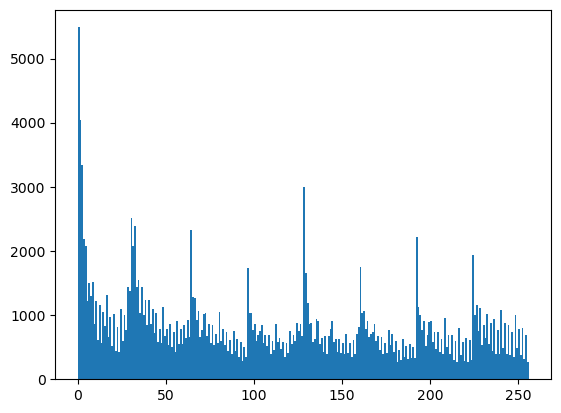

In [284]:
# Read the image
image = np.fromfile("dadosTP2/LenaGray.tif", dtype="uint8")

# Calculate histogram
histogram, bins, patches = plt.hist(image, 256, [0,256])
symbols = np.arange(0,256)
# Generate Huffman table
t0 = time()
tabela_codigo = gen_huff_table(symbols, histogram)
t1 = time()

print("Huffman table:", tabela_codigo)
print("Time taken:", t1 - t0)

In [285]:
with open("dadosTP2/DecUniversalDH.txt", "r") as file:
    text = file.read()

symbols_txt, occurrences_txt = sort_symbols_occurences(text)

huff_table = gen_huff_table(symbols_txt, occurrences_txt)

print("Tabela de Huffman:")
for symbol, code in huff_table.items():
    print(f"Symbol: {symbol}, Huffman Code: {code}")

Tabela de Huffman:
Symbol:  , Huffman Code: 110
Symbol: e, Huffman Code: 001
Symbol: a, Huffman Code: 000
Symbol: o, Huffman Code: 1110
Symbol: i, Huffman Code: 1010
Symbol: s, Huffman Code: 1001
Symbol: d, Huffman Code: 0110
Symbol: r, Huffman Code: 0101
Symbol: t, Huffman Code: 11110
Symbol: n, Huffman Code: 10110
Symbol: m, Huffman Code: 10000
Symbol: u, Huffman Code: 01110
Symbol: c, Huffman Code: 01000
Symbol: l, Huffman Code: 111111
Symbol: p, Huffman Code: 101111
Symbol: 
, Huffman Code: 011110
Symbol: g, Huffman Code: 1111100
Symbol: ,, Huffman Code: 1011101
Symbol: v, Huffman Code: 1011100
Symbol: ., Huffman Code: 0111111
Symbol: ç, Huffman Code: 1000101
Symbol: ã, Huffman Code: 0111110
Symbol: f, Huffman Code: 0100101
Symbol: b, Huffman Code: 0100100
Symbol: q, Huffman Code: 10001111
Symbol: h, Huffman Code: 10001001
Symbol: í, Huffman Code: 01001111
Symbol: A, Huffman Code: 01001101
Symbol: é, Huffman Code: 111110111
Symbol: T, Huffman Code: 111110101
Symbol: º, Huffman Code

b) Meça a entropia e o número médio de bits por símbolo. Calcule a eficiência.

In [286]:
# Calculate entropy and average number of bits per symbol
probabilities = histogram / histogram.sum()
entropy = -np.sum([p * math.log2(p) for p in probabilities if p > 0])
average_bits = np.sum([len(tabela_codigo[s]) * p for s, p in zip(symbols, probabilities) if s in tabela_codigo])

# Calculate efficiency
efficiency = entropy / average_bits if average_bits else 0

print("Entropy (bits/symbol):", entropy)
print("Average bits per symbol:", average_bits)
print("Efficiency:", efficiency)

Entropy (bits/symbol): 7.761434296010263
Average bits per symbol: 7.791235567908168
Efficiency: 0.996175026202435


c) Faça a codificação da mensagem contida no ficheiro (usando a função realizada no ponto 2). Meça o tempo
que a função demora a fazer a codificação.

In [287]:
t2 = time()
seq_bit0 = encode_huff(image, tabela_codigo)
t3 = time()
print("Time taken:", t3 - t2)

Time taken: 0.04453086853027344


d) Grave um ficheiro com a mensagem codificada, usando a função realizada no ponto 4. Veja o tamanho do
ficheiro.

In [288]:
seq_bit1 = encode_table(tabela_codigo)
filename = "Lena.bin"
write2file(seq_bit1, filename)

file_size = os.path.getsize(filename)
print("File size:", file_size, "bytes")

File size: 860 bytes


e) Leia do ficheiro o conjunto de bits, usando a função realizada no ponto 5.

In [289]:
read_file(filename)

'001100000100000110001110010001100101001011100010011001000111000011010110011001100000010001100110011001000000111011000110100111111011000100111001001100101110111001100111110100001101001101100110011001100011101011110010001100100011010011000001100010011011000110000101011011100100110110101010011000100110010001110011001000110011001101000111110001110000111000001101100110111110011001100110101110110011001101100101101110010001110000101100110010001110010100100110001001101100011010001101110010110110110001101010010100110110001101100010010110100001100000001100110011001110000001010001101010001001110001001100000001000110001001100110011000000001001100010011001011111011110010001100100011011011111000110100001110001111001011000100111001001100111111000111001000110010001110001110110111001000110100111010111101000011001011100111110010001101000011000011100110110001001101100011001011100011110110001110001110001011000100110100110111111110000011000011011101111001001110001101101111000100110110001100011101110011011

f) Faça a descodificação da mensagem (usando a função realizada no ponto 3.) Meça o tempo que a função
demora a fazer a descodificação.

g) Compare a mensagem descodificada com a original e verifique que são iguais (erro nulo).